In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from collections import Counter
from string import punctuation

from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
#nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import skimage

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from keras.preprocessing.image import (load_img
                                       , array_to_img
                                       , img_to_array
                                       , ImageDataGenerator)
import keras

Using TensorFlow backend.


In [2]:
file = open('photo.json', 'r')

In [3]:
stop = 200000
all_data = []

for i, line in enumerate(file):
    if i%200000 == 0:
        print(i)
    if i == stop:
        break
    
    data = json.loads(line)
    
    photo_id = data['photo_id']
    business_id = data['business_id']
    caption = data['caption']
    label = data['label']
    
    all_data.append([photo_id
                     , business_id
                     , caption
                     , label])
    
df = pd.DataFrame(all_data, columns = ['photo_id'
                                       , 'business_id'
                                       , 'caption'
                                       , 'label'])

file.close()

0


In [4]:
df.head()

,photo_id,business_id,caption,label
0,MllA1nNpcp1kDteVg6OGUw,rcaPajgKOJC2vo_l3xa42A,,inside
1,YjxBE88Bf6CmTEF2LP1UNA,Kn23LDd740SBVJ7mum0fwg,,inside
2,1f7izSjM0WjkDRIVbPy1yw,ZkGDCVKSdf8m76cnnalL-A,,food
3,NcSlcDTEEeOaixotOPk-rA,bF8gv7k_rwZtiDLP2ZB04w,,inside
4,5IiIo5UKEW0lWqZ6sWrY_A,50Anorn0DJXFhBr9a9_gHQ,,inside


In [5]:
df.label.value_counts()

food       114874
inside      52448
drink       18121
outside     11534
menu         3023
Name: label, dtype: int64

In [6]:
df['photo_path'] = '/home/david/Downloads/photos/'+ df.photo_id + '.jpg'

In [7]:
df.head(1)

,photo_id,business_id,caption,label,photo_path
0,MllA1nNpcp1kDteVg6OGUw,rcaPajgKOJC2vo_l3xa42A,,inside,/home/david/Downloads/photos/MllA1nNpcp1kDteVg...


In [8]:
classes_ctn = pd.DataFrame(df.label.value_counts())
classes_ctn

,label
food,114874
inside,52448
drink,18121
outside,11534
menu,3023


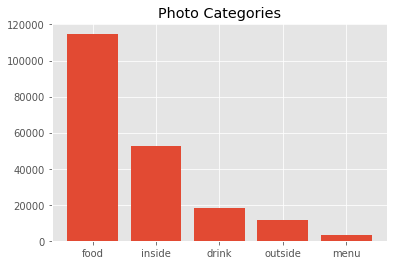

In [9]:
plt.bar(classes_ctn.index, classes_ctn.label)
plt.title('Photo Categories')
plt.savefig('photo_cat_ctn.png');

In [10]:
df_short_balanced = df.groupby('label').apply(lambda x: x.sample(n=3023)).reset_index(drop=True)

In [11]:
df_short_balanced.label.value_counts()

drink      3023
inside     3023
outside    3023
menu       3023
food       3023
Name: label, dtype: int64

In [12]:
df_short_balanced.shape

(15115, 5)

In [13]:
img = cv2.imread('/home/david/Downloads/photos/'+ df.photo_id.iloc[0] + '.jpg'
                 , 0) #1 is color, 0, is grayscale, -1 is alpha channel


In [14]:
print(img)

[[  0  43   8 ...  11  32   0]
 [ 34 150 158 ... 142 115  19]
 [  8 176 200 ... 171 172  29]
 ...
 [ 11  15  15 ...  18  17   4]
 [ 17  17  22 ...  10  13   4]
 [  3   9  14 ...   4  10   2]]


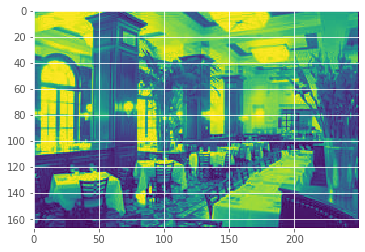

In [15]:
plt.imshow(img);

Reference: https://github.com/netik1020/Concise-iPython-Notebooks-for-Deep-learning/blob/master/Image_Classifier/skin_cancer_classification_1.ipynb

In [16]:
df_short_balanced.head(1)

,photo_id,business_id,caption,label,photo_path
0,ZHnrSA_s5SCUIfkY6zw2PA,G6BwYw_0_atLPTzI1uokIA,Daddy's Michelada,drink,/home/david/Downloads/photos/ZHnrSA_s5SCUIfkY6...


In [17]:
img1 = load_img(df_short_balanced.photo_path.iloc[0]
              , grayscale=True
              , target_size=(150,150))

img2 = load_img(df_short_balanced.photo_path.iloc[1]
              , grayscale=True
              , target_size=(150,150))

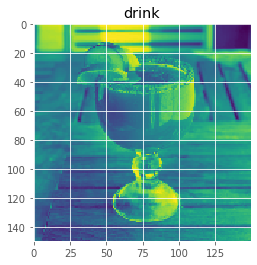

In [18]:
plt.imshow(img1)
plt.title(df_short_balanced.label.iloc[0]);

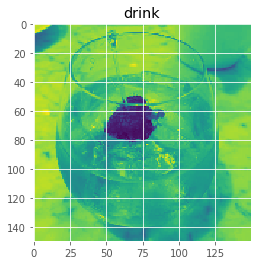

In [19]:
plt.imshow(img2)
plt.title(df_short_balanced.label.iloc[1]);

In [20]:
X = [load_img(df_short_balanced.photo_path.iloc[x]
                      , grayscale=True
                      , target_size=(128,128)) for x in range(len(df_short_balanced))]

In [21]:
len(X)

15115

In [22]:
test_img = img_to_array(X[0]).flatten()

In [23]:
type(test_img)

numpy.ndarray

In [24]:
photo_arr = []
for i in range(len(df_short_balanced)):
    photo_arr.append(img_to_array(X[i]).flatten())

In [25]:
len(photo_arr)

15115

In [26]:
len(photo_arr[0])

16384

In [27]:
pca = PCA(n_components=1000)

In [28]:
photo_pca = pca.fit(photo_arr)

In [29]:
photo_red = photo_arr @ photo_pca.components_[0:5].T

In [30]:
photo_pca.components_[0:1000].T[4]

array([ 9.33388919e-03, -1.19354071e-02, -5.95695065e-03,  8.16125388e-03,
        2.51792438e-04,  1.19291017e-02,  8.41625360e-03, -9.44016613e-03,
       -5.22148929e-03, -9.78687117e-03,  7.62116925e-03,  9.80742132e-04,
       -3.74540782e-03, -1.01105744e-02, -1.04913107e-02,  9.46797135e-03,
       -3.39527785e-03, -9.97660166e-03, -1.02739139e-02,  1.00202062e-02,
       -6.04873089e-03, -7.47639632e-03,  8.06611545e-03, -2.90090531e-03,
       -4.83288505e-03,  4.78045716e-03,  8.95070416e-03,  1.14781618e-02,
        7.28216700e-03, -5.96998168e-04,  3.65575592e-03,  1.06307716e-03,
        1.17560940e-02, -1.67749278e-02,  7.23999900e-03,  1.63668593e-04,
       -7.29616188e-04, -5.37230198e-03, -1.57542984e-03, -1.20919338e-02,
       -5.60812046e-03, -4.89451954e-03,  1.33397764e-02, -1.64945963e-03,
       -4.50397915e-03, -4.95744757e-03,  2.32272020e-03,  1.81986422e-02,
        3.15883020e-03, -1.20073993e-03, -7.66339101e-03, -1.38117169e-02,
       -5.53691824e-03,  

In [31]:
photo_red[4]

array([14532.54969732,  8148.27126547,  -617.46369874,  -590.85581075,
       -2882.76911057])

In [32]:
photo_arr[0][:5]

array([122., 141., 178., 210., 227.], dtype=float32)

In [33]:
len(photo_red[0])

5

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(photo_arr
                                                   , df_short_balanced.label
                                                   , stratify=df_short_balanced.label
                                                   , random_state=42)

# SVM Classifier: Takes TOO Long!!!

In [35]:
# from sklearn import svm
# model = svm.SVC(kernel='linear'
#                , probability=True)
# model.fit(X_train, y_train)

In [36]:
# y_pred = model.predict(X_test)

In [37]:
# y_pred

In [38]:
# y_pred[0]

In [39]:
# y_test_val = y_test.values
# y_test_val

In [40]:
# y_test_val[0]

In [41]:
# print(len(y_pred))
# print(len(y_test))

In [42]:
# test = [y_pred[x]==y_test_val[x] for x in range(len(y_pred))]

In [43]:
#t = 0
# for x in test:
#     if x==True:
#         t+=1
# t        

In [44]:
# t/len(y_pred)

# Stochastic GD Model

In [45]:
sgd_clf = SGDClassifier(random_state=42
                        , max_iter=1000
                        , tol=1e-3)


In [46]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [47]:
y_pred = sgd_clf.predict(X_test)

In [48]:
y_pred

array(['food', 'food', 'food', ..., 'drink', 'menu', 'menu'], dtype='<U7')

In [49]:
y_pred[0]

'food'

In [50]:
y_test_val = y_test.values
y_test_val

array(['menu', 'inside', 'food', ..., 'food', 'drink', 'menu'],
      dtype=object)

In [51]:
print(len(y_pred))
print(len(y_test))

3779
3779


In [52]:
test = [y_pred[x]==y_test_val[x] for x in range(len(y_pred))]

In [53]:
t = 0
for x in test:
    if x==True:
        t+=1
t   

1178

In [56]:
t/len(y_pred)

0.3117226779571315

In [57]:
cross_val_score(sgd_clf, photo_arr, df_short_balanced.label, cv=5)

array([0.31140496, 0.31867769, 0.30446281, 0.31390728, 0.32152318])

In [58]:
sgd_clf_cv_5 = np.array([0.31140496, 0.31867769, 0.30446281, 0.31390728, 0.32152318])

In [59]:
sgd_clf_cv_5.mean()

0.31399518400000004

In [ ]:
plt.imshow(X[0]);

# HOG These Images!!!

In [ ]:
fd, hog_image = hog(load_img(df_short_balanced.photo_path.iloc[0]
                            , grayscale=True
                            , target_size=(256,256))
                    , orientations=8
                    , pixels_per_cell=(4, 4)
                    , cells_per_block=(1, 1)
                    , visualize=True
                    , multichannel=False)
plt.imshow(hog_image)
plt.title(df_short_balanced.label.iloc[0]);

In [61]:
print(len(hog_image.flatten()))
print(256**2)

65536
65536


In [62]:
def hog_img(idx):
    fd, hog_image = hog(load_img(df_short_balanced.photo_path.iloc[idx]
                            , grayscale=True
                            , target_size=(256,256))
                    , orientations=8
                    , pixels_per_cell=(4, 4)
                    , cells_per_block=(1, 1)
                    , visualize=True
                    , multichannel=False)
    return hog_image.flatten()

In [ ]:
X_hog = [hog_img(x) for x in range(len(df_short_balanced))]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_hog
                                                   , df_short_balanced.label
                                                   , stratify=df_short_balanced.label
                                                   , random_state=42)

In [ ]:
sgd_clf = SGDClassifier(random_state=42
                        , max_iter=1000
                        , tol=1e-3)

In [ ]:
sgd_clf.fit(X_train, y_train)

In [ ]:
y_pred = sgd_clf.predict(X_test)

In [ ]:
np.mean(y_pred == y_test)

In [ ]:
parameters = {'alpha': [0.1, 0.01, 0.001, 0.0001]
              , 'max_iter':[10, 100, 1000]
              , 'validation_fraction': [0.1, 0.15, 0.2, 0.25]
              , 'tol': [0.1, 0.01, 0.001]}

In [ ]:
grid_srch = GridSearchCV(sgd_clf, parameters, cv=5)

In [ ]:
grid_srch.fit(X_train, y_train)